In [17]:
import torch
from torch import nn
from d2l import torch as d2l

## 加载数据

In [18]:
batch_size = 512
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

## 定义模型

In [19]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 96, 11, stride=4, padding=1),  # [96, 54, 54]
            nn.ReLU(),
            nn.MaxPool2d(3, 2)  # [96, 26, 26]
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, stride=1, padding=2),  # [256, 26, 26]
            nn.ReLU(),
            nn.MaxPool2d(3, 2)  # [256, 12, 12]
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, padding=1),  # [384, 12, 12]
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # [384, 12, 12]
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # [256, 12, 12]
            nn.ReLU(),
            nn.MaxPool2d(3, 2)  # [256, 5, 5]
        )
        self.linear = nn.Sequential(
            nn.Flatten(),  # [256 * 5 * 5]
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )
    def forward(self, X):
        X = X.view(-1, 1, 224, 224)
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        y = self.linear(X)
        return y


## 训练

In [20]:
# 模型准确率评估函数
def evaluate_accuracy(model, test_iter, device):
    metrics = d2l.Accumulator(2)
    model.to(device)
    model.eval()
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        metrics.add(d2l.accuracy(y_hat, y), y.numel())
    return metrics[0] / metrics[1]

In [21]:
# 训练函数
def train(model, train_iter, test_iter, loss_fn, optimizer, num_epochs, device):
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train_loss', 'train_acc', 'test_acc'])
    metrics = d2l.Accumulator(3)
    timer = d2l.Timer()
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        metrics.reset()
        timer.start()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                metrics.add(loss * y.numel(), d2l.accuracy(y_hat, y), y.numel())
        timer.stop()
        print(f'speed: {metrics[2] / timer.times[-1]:.1f} samples/sec')
        test_acc = evaluate_accuracy(model, test_iter, d2l.try_gpu())
        print(f'train_acc: {metrics[1] / metrics[2]:.3f}, test_acc: {test_acc}')
        animator.add(epoch + 1,
                     (metrics[0] / metrics[2], metrics[1] / metrics[2], test_acc))
    print(f'speed: {metrics[2] / timer.avg():.1f} samples/sec on {device}.')
    print(f'train_acc: {metrics[1] / metrics[2]:.3f}, test_acc: {test_acc}.')

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/d2l/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/homebrew/anaconda3/envs/d2l/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/homebrew/anaconda3/envs/d2l/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/homebrew/anaconda3/envs/d2l/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/homebrew/anaconda3/envs/d2l/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/homebrew/anaconda3/envs/d2l/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/homebrew/anaconda3/envs/d2l/lib/python3

KeyboardInterrupt: 

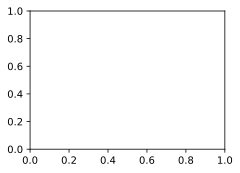

In [22]:
lr = 0.1
num_epochs = 10

model = AlexNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

train(model,  train_iter, test_iter, loss_fn, optimizer, num_epochs, d2l.try_gpu())